## Import

In [183]:
from pathlib import Path

current = Path.cwd().parent.parent
current

PosixPath('/home/flecourtier/Bureau/Thèse')

In [184]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
from scimba.equations.domain import SpaceTensor
from scar.geometry.StandardMesh import create_test_sample
from scar.utils import read_config,create_tree,get_class
from scar.equations.run_EikonalLap2D import *
from scar.geometry import Geometry2D

# from scar.solver.solver_fem import FEMSolver
# from scar.solver.solver_phifem import PhiFemSolver
# from scar.correction.correct_pred import *

import torch
from torch.autograd import grad as grad_torch
import dolfin as df
from dolfin import FunctionSpace,Function

import matplotlib.pyplot as plt

In [186]:
form = "Bean"
num_config = 3
sdf_run = run_EikonalLap2D

In [187]:
dir_name = "../../networks/EikonalLap2D/"+form+"/"
models_dir = dir_name+"models/"
config_filename = models_dir+"config_"+str(num_config)+".json"
model_filename = models_dir+"model_"+str(num_config)+".pth"

## Mask

In [188]:
geom_class = get_class(form,Geometry2D)
form = geom_class()

In [189]:
dict_config = read_config(config_filename)
eik,trainer = sdf_run(form,num_config,dict_config,new_training = False,createxyzfile=False)
plt.close('all')

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Bean/models/model_3.pth
jsbdbshd


In [190]:
def create_mask(nb_vert=10):
    x = np.linspace(form.bord_a, form.bord_b, nb_vert)
    y = np.linspace(form.bord_a2, form.bord_b2, nb_vert)
    XXYY = np.meshgrid(x,y)
    XXYY_ = np.array(XXYY).reshape(2,-1).T
    X_test,mu_test = create_test_sample(XXYY_,trainer.pde.parameter_domain)
    
    pred = eik(X_test,mu_test)
    pred = pred.reshape(nb_vert,nb_vert).cpu().detach().numpy()
    
    mask = np.zeros((nb_vert,nb_vert),dtype=int)
    for i in range(nb_vert):
        for j in range(nb_vert):
            if pred[i,j] < 0.:
                mask[i,j] = 1
                
    return mask,XXYY

nb_vert = 200
mask,XXYY = create_mask(nb_vert)
XX,YY = XXYY

In [191]:
# plt.figure()
# for i in range(nb_vert):
#     for j in range(nb_vert):
#         if mask[i,j] == 1:
#             plt.plot(XX[i,j],YY[i,j],'r+')  
#         else:
#             plt.plot(XX[i,j],YY[i,j],'b+')
# plt.show()

In [192]:
# creer un padding pour le masque (-1)
mask_pad = -np.ones((nb_vert+2,nb_vert+2),dtype=int)
mask_pad[1:-1,1:-1] = mask


In [193]:
def is_bc(i,j,mask):
    # (i,j) est 1
    # au moins 1 des ses 4 voisins est 0
    
    if mask[i,j] == 1:
        if mask[i-1,j] == 0 or mask[i+1,j] == 0 or mask[i,j-1] == 0 or mask[i,j+1] == 0:
            return True
    return False

# on mets les bc à 2
def set_bc(ind_bc,mask):
    for (i,j) in ind_bc:
        mask[i,j] = 2
    return mask


In [194]:
bc_ind = []
bc_points = []
# looking for coordinates of the boundary
for i in range(1,nb_vert+1):
    for j in range(1,nb_vert+1):
        if is_bc(i,j,mask_pad):
            bc_ind.append((i,j))
            bc_points.append((XX[i-1,j-1],YY[i-1,j-1]))

In [195]:
for i,j in bc_ind:
    mask_pad = set_bc(bc_ind,mask_pad)

In [196]:
int_ind = []
int_points = []
ext_ind = []
ext_points = []
for i in range(1,nb_vert+1):
    for j in range(1,nb_vert+1):
        if mask_pad[i,j] == 1:
            int_ind.append((i,j))
            int_points.append((XX[i-1,j-1],YY[i-1,j-1]))
        elif mask_pad[i,j] == 0:
            ext_ind.append((i,j))
            ext_points.append((XX[i-1,j-1],YY[i-1,j-1]))

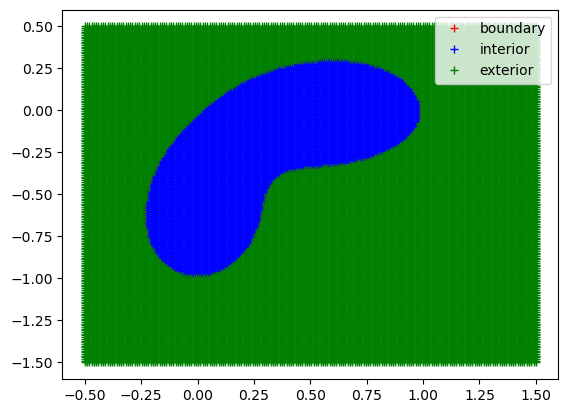

In [197]:
plt.figure()
plt.plot([p[0] for p in bc_points],[p[1] for p in bc_points],'r+',label='boundary')
plt.plot([p[0] for p in int_points],[p[1] for p in int_points],'b+',label='interior')
plt.plot([p[0] for p in ext_points],[p[1] for p in ext_points],'g+',label='exterior')
# form.plot_curve(color="black")
plt.legend()
plt.show()

In [198]:
mask_pad = mask_pad[1:-1,1:-1]

In [199]:
filename = form.__class__.__name__+"_lv"+str(num_config)+"_"+str(nb_vert)+"_allbc.npy"
filename = current / "TestClassifieur" / "masks" / filename
np.save(filename,mask_pad)